In [3]:
import numpy as np

from evaluation.mc import *
from utils.misc import *
from policies import *
import gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from tqdm import tqdm


In [3]:
def sample_episode_lim(env, policy,limit=100):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length.
        Hint: Do not include the state after the termination in the list of states.
    """
    states = []
    actions = []
    rewards = []
    dones = []

    state = env.reset()

    for i in range(limit):
        states.append(state)

        action = policy.sample_action(state)
        state, reward, done, _ = env.step(action)

        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        if done == True:
            break

    return states, actions, rewards, dones

In [4]:
import gym
from gym import spaces
from gym.utils import seeding

class NChainEnv(gym.Env):
    """n-Chain environment
    This game presents moves along a linear chain of states, with two actions:
     0) forward, which moves along the chain but returns no reward
     1) backward, which returns to the beginning and has a small reward
    The end of the chain, however, presents a large reward, and by moving
    'forward' at the end of the chain this large reward can be repeated.
    At each action, there is a small probability that the agent 'slips' and the
    opposite transition is instead taken.
    The observed state is the current state in the chain (0 to n-1).
    This environment is described in section 6.1 of:
    A Bayesian Framework for Reinforcement Learning by Malcolm Strens (2000)
    http://ceit.aut.ac.ir/~shiry/lecture/machine-learning/papers/BRL-2000.pdf
    """
    def __init__(self, n=5, slip=0.2, small=2, large=10):
        self.n = n
        self.slip = slip  # probability of 'slipping' an action
        self.small = small  # payout for 'backwards' action
        self.large = large  # payout at end of chain for 'forwards' action
        self.state = 0  # Start at beginning of the chain
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(self.n)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        if self.np_random.rand() < self.slip:
            action = not action  # agent slipped, reverse action taken
            
            
        #added 
        if self.state == 0 and action:
            done = True
        elif self.state == n-1 and not action:
            done = True
        else:
            done = False
        #this part
            
        if action:  # 'backwards': go back to the beginning, get small reward
            reward = self.small
            self.state = 0
        elif self.state < self.n - 1:  # 'forwards': go up along the chain
            reward = 0
            self.state += 1
        else:  # 'forwards': stay at the end of the chain, collect large reward
            reward = self.large
        
        return self.state, reward, done, {}

    def reset(self):
        self.state = 0
        return self.state

  5%|▍         | 451/10000 [00:00<00:02, 4501.31it/s]

Discrete(2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
1
Episode 0:
States [0, 1, 2, 0]
Actions [0, 0, 1, 1]
Rewards [0, 0, 2, 2]
Dones [False, False, False, True]

Episode 1:
States [0, 1, 0, 1, 2, 3, 4, 5, 6]
Actions [0, 1, 0, 0, 0, 0, 0, 0, 0]
Rewards [0, 2, 0, 0, 0, 0, 0, 0, 10]
Dones [False, False, False, False, False, False, False, False, True]

Episode 2:
States [0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0]
Actions [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Rewards [0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2]
Dones [False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]



100%|██████████| 50000/50000 [00:08<00:00, 5600.24it/s]


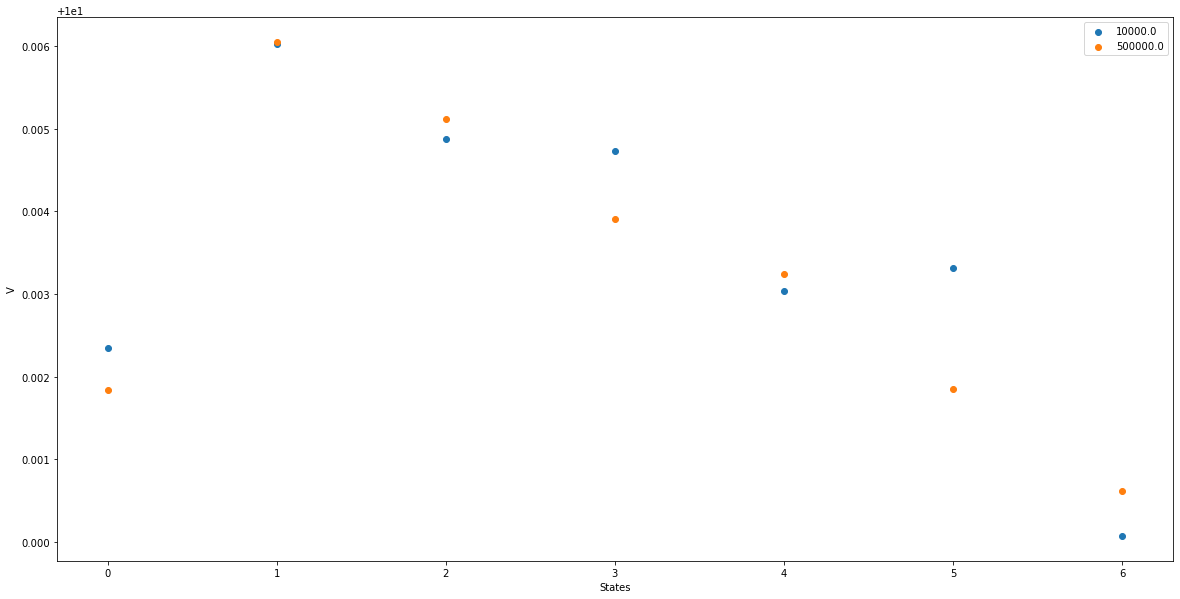

In [6]:
# from gym.envs.toy_text import NChainEnv
n = 7

Q = np.zeros((n, 2))

for state in range(n):
    Q[state,  0] = 1

env = NChainEnv(n=n, slip = 0.0)
print(env.action_space)
print(Q)

# Let's sample some episodes
actions = [0,1]
target_policy = EpsilonGreedyPolicy(actions, Q, 0.001)
behavior_policy = RandomPolicy(actions)
print(1)
for episode in range(3):
    trajectory_data = sample_episode(env, behavior_policy)
    print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))
# print(2)
np.random.seed(42)
V_10k = mc_weighted_importance_sampling(env,behavior_policy , target_policy, 10000, sample_episode)
V_50k = mc_weighted_importance_sampling(env, behavior_policy, target_policy, 50000, sample_episode)


Vs = [V_10k, V_50k]
x = np.arange(Q.shape[0])
fig = plt.figure(figsize=(20, 10))

for i in Vs:
    number_episodes = 1e4 if i == V_10k else 5*1e5
    plt.scatter(x,[i[j] for j in x], label= "%s" %(number_episodes))
plt.xlabel('States')
plt.ylabel('V')
plt.legend()
plt.show()



### First we run the env with random agent

# print(V_10k)


  2%|▏         | 226/10000 [00:00<00:04, 2254.63it/s]

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
Discrete(4)
1
Episode 0:
States [0, 0, 0, 4, 8, 8, 4, 4, 8, 4, 8, 9, 13, 13]
Actions [0, 0, 1, 1, 0, 3, 0, 1, 3, 1, 2, 1, 1, 0]
Rewards [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Dones [False, False, False, False, False, False, False, False, False, False, False, False, False, True]

Episode 1:
States [0, 0, 0, 1]
Actions [3, 0, 2, 1]
Rewards [0.0, 0.0, 0.0, 0.0]
Dones [False, False, False, True]

Episode 2:
States [0, 1, 0, 1]
Actions [2, 0, 2, 1]
Rewards [0.0, 0.0, 0.0, 0.0]
Dones [False, False, False, True]



100%|██████████| 50000/50000 [00:20<00:00, 2393.33it/s]


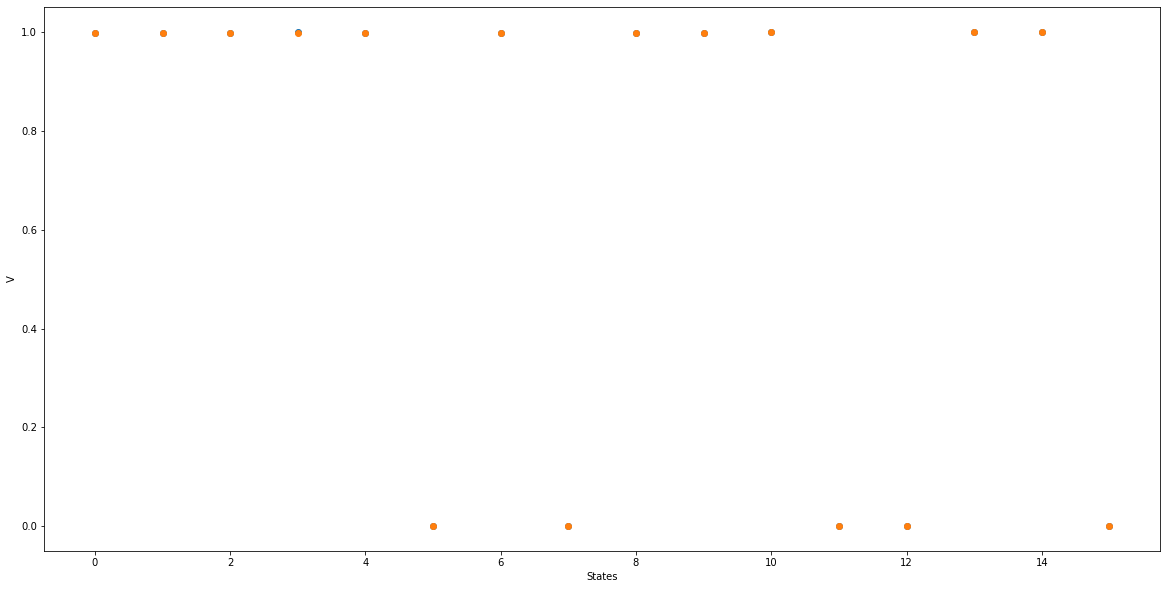

In [4]:
from gym.envs.toy_text import FrozenLakeEnv

action_map = {
  0: "D",
  1: "R",
  2: "D",
  3: "L",
  4: "D",
  5: "U",
  6: "D",
  7: "U",
  8: "R",
  9: "D",
  10: "D",
  11: "U",
  12: "U",
  13: "R",
  14: "R",
  15: "D",

}
index = {"L": 0, "D": 1, "R": 2, "U": 3}

Q = np.zeros((16, 4))

for state, action in action_map.items():
    Q[state,  index[action]] =1

    
    
    

    
    
    
    
    
print(Q)
env = FrozenLakeEnv(is_slippery=False)
print(env.action_space)

# Let's sample some episodes
actions = [0,1,2,3]
target_policy = EpsilonGreedyPolicy(actions, Q, 0.001)
behavior_policy = RandomPolicy(actions)
print(1)
for episode in range(3):
    trajectory_data = sample_episode_lim(env, behavior_policy)
    print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))
# print(2)
np.random.seed(42)
V_10k = mc_weighted_importance_sampling(env,behavior_policy , target_policy, 10000, sample_episode_lim)
V_50k = mc_weighted_importance_sampling(env, behavior_policy, target_policy, 50000, sample_episode_lim)


Vs = [V_10k, V_50k]
x = np.arange(Q.shape[0])
fig = plt.figure(figsize=(20, 10))

for i in Vs:
    number_episodes = 1e4 if i == V_10k else 5*1e4
    plt.scatter(x,[i[j] for j in x], label= str(number_episodes))
plt.xlabel('States')
plt.ylabel('V')
plt.show()



### First we run the env with random agent

# print(V_10k)

In [ ]:
from gym.envs.toy_text import BlackJackEnv
n = 7

Q = np.zeros((n, 2))

for state in range(n):
    Q[state,  0] = 1

env = NChainEnv(n=n, slip = 0.0)
print(env.action_space)
print(Q)

# Let's sample some episodes
actions = [0,1]
target_policy = EpsilonGreedyPolicy(actions, Q, 0.001)
behavior_policy = RandomPolicy(actions)
print(1)
for episode in range(3):
    trajectory_data = sample_episode_lim(env, behavior_policy)
    print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))
# print(2)
np.random.seed(42)
V_10k = mc_weighted_importance_sampling(env,behavior_policy , target_policy, 10000, sample_episode_lim)
V_50k = mc_weighted_importance_sampling(env, behavior_policy, target_policy, 50000, sample_episode_lim)


Vs = [V_10k, V_50k]
x = np.arange(Q.shape[0])
fig = plt.figure(figsize=(20, 10))

for i in Vs:
    number_episodes = 1e4 if i == V_10k else 5*1e5
    plt.scatter(x,[i[j] for j in x], label= str(number_episodes))
plt.xlabel('States')
plt.ylabel('V')
plt.show()



### First we run the env with random agent

# print(V_10k)

In [34]:
from gym.envs.toy_text import BlackjackEnv
import itertools
BlackjackEnv??

In [30]:
player_values = [i for i in range(12, 22)]
dealer_values = [i for i in range(1,11)]
usable_aces = [True, False]

In [35]:
states = []
for player in player_values:
    for dealer in dealer_values:
        for ace in usable_aces:
            states.append((player,dealer,ace))


In [37]:
Q_s = np.zeros((len(states), 2))